In [1]:
# Relevant Libraries
import sys

sys.path.append("./../..")

from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from InternalLibrary.StatisticalFunctions import stat_corr_single
from scipy.optimize import curve_fit

from tqdm import tqdm

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE
from sbi.utils.user_input_checks import (
    process_prior,
)
import torch
import imageio

# WHAT TO DO

## The Model
- Improve the initial description of the model.
- Improve readability of the simulator, with possible validation
- Improve description of bare `x` traces
- Improve theoretical observable validation ($\chi^2$, statistical tests, etc.)
    - What observables do we have ?
    - Improve autocorrelation exponential decay
    - How does the model behave with respect to the number of traces?
- Add entropy description !!!

## THE SBI
- Improve the description of the SBI algorithm
- SBI with bare `x` traces: results and discussion. Be *detailed*.
- SBI with only autocorrelation trace: results and discussion. Be *detailed*.
- SBI with subsampling of autocorrelation traces: results and discussion. Be *detailed*.
- SBI with only autocorrelation fit: results and discussion. Be *detailed*.
- For every SBI trial, we need to have a comprehensive way to test the quality of the fit. HOW? Try a lot and see the dispersion? The error? Which error? How does the stocastichity affect the result and the error?
- SBI with best trial and multi-round inference: results and discussion. Be *detailed*. Try a lot of times.

# Ornstein-Uhlenbeck Process

DESCRIPTION

In [2]:
# The Simulator
@jit
def OrnsteinUhlenbeck(param, n_sim, dt = 0.01, TotalT = 1):
    k = param[0]
    D = param[1]
    time_steps_amount = np.int64(TotalT/dt)

    x = np.zeros((1, n_sim))
    x_tilde = np.zeros((1, n_sim))
    x_trace = np.zeros((n_sim, time_steps_amount))
    
    for t in np.arange(0, time_steps_amount):
        
        x_tilde[:]   = x[:] + -k * x[:] * dt + np.sqrt(2*D) * np.random.normal(0, np.sqrt(dt), size = (1,n_sim))
        x[:]         = x_tilde + (+k * x[:] - k*x_tilde[:])*dt /2
        x_trace[:,t] = x[:,]
    
    return x_trace

Let us define the parameters of our model and simulation. As this is a highly stochastic model, we will run the simulation for a large number of particles.

In [64]:
ModelParameter = [10., 3.] # [k, D]
NumberOfParticles = 1000 # Number of particles to simulate
TotalTime = 20 # Total time of simulation
dt = 1e-2 # Time step
t = np.arange(0, TotalTime, dt) # Time vector
prior_limits = {"k": [10.0,20.0],
                "D": [0.0,2.0]}

Let be noted that `ModelParameter` is a matrix of shape `(2, n_particles)` where the first column is the elastic constant $k$ and the second column is diffusion constant $D$.

Let's simulate a single example particle and visualize its trajectory.

In [6]:
# Run the simulation
x_trace = OrnsteinUhlenbeck(ModelParameter, n_sim = 10, dt = dt, TotalT = TotalTime)

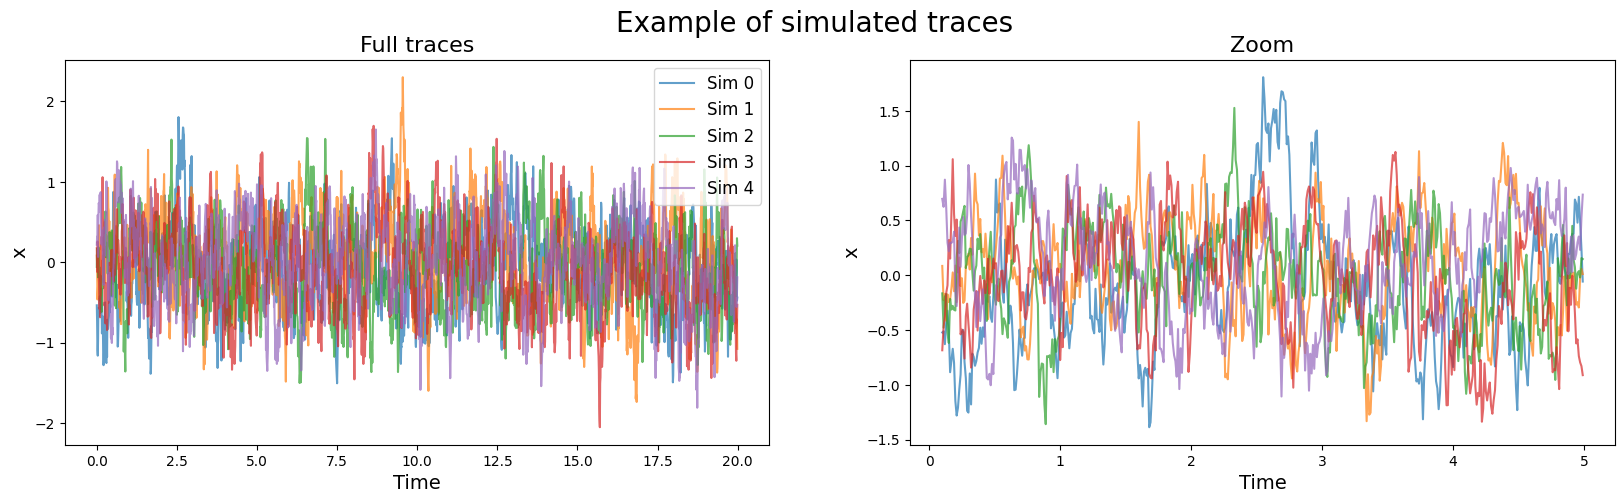

In [7]:
# Example of simulated traces
plt.figure(figsize=(20, 5))
plt.suptitle("Example of simulated traces", fontsize=20)

plt.subplot(121)
for i in range(min([10, 5])):
    plt.plot(t[:], x_trace[i], label=f"Sim {i}", alpha=0.7)
plt.title("Full traces", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("x", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
for i in range(min([10, 5])):
    plt.plot(t[10:500], x_trace[i, 10:500], label=f"Sim {i}", alpha=0.7)
plt.title("Zoom", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("x", fontsize=14);


## Theoretical Observables

We know check the validity of our simulator against some well-known theoretical observables.
First we will check the first moment. This is the mean position of the particle at time $t$, and should be approximatly 0 at all times.

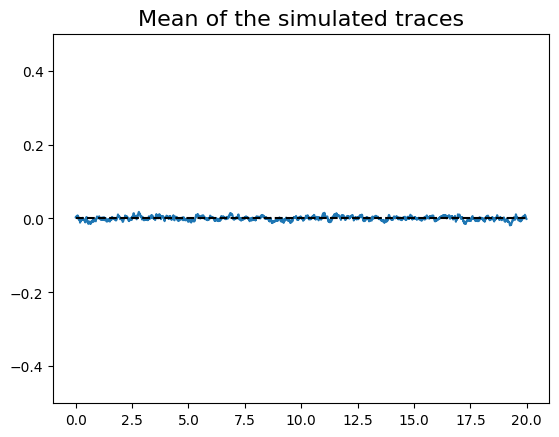

In [8]:
# Generate some traces
x = OrnsteinUhlenbeck(ModelParameter, n_sim = 10000, dt = dt, TotalT = TotalTime)
simulated_mean = np.mean(x, axis = 0)

plt.plot(t, simulated_mean, label = "Mean")
plt.title("Mean of the simulated traces", fontsize=16)
plt.hlines(0, 0, TotalTime, color = "black", linestyle = "--")
plt.ylim([-0.5, 0.5]);

We now check the second moment, that should be given by the following equation:
$$
\langle x^2 \rangle = \frac{D}{2k} (1 - e^{-2kt})
$$

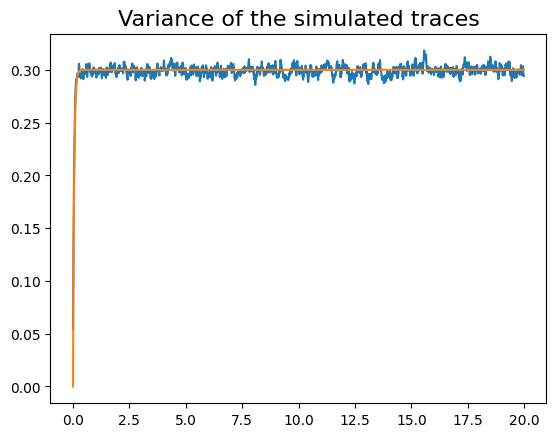

In [12]:
x = OrnsteinUhlenbeck(ModelParameter, n_sim = 10000, dt = dt, TotalT = TotalTime)
simulated_variance = np.var(x, axis = 0)

def OU_variance(t, k, D):
    return D / (k) * (1 - np.exp(-2*k*t))

plt.plot(t, simulated_variance, label = "Variance")
plt.plot(t, OU_variance(t, ModelParameter[0], ModelParameter[1]), label = "Theoretical variance")
plt.title("Variance of the simulated traces", fontsize=16);

Now we check the autocorrelation function, that should be given by the following equation:
$$
\langle x(t) x(t + \tau) \rangle = \frac{D}{k} e^{-2k \tau}
$$

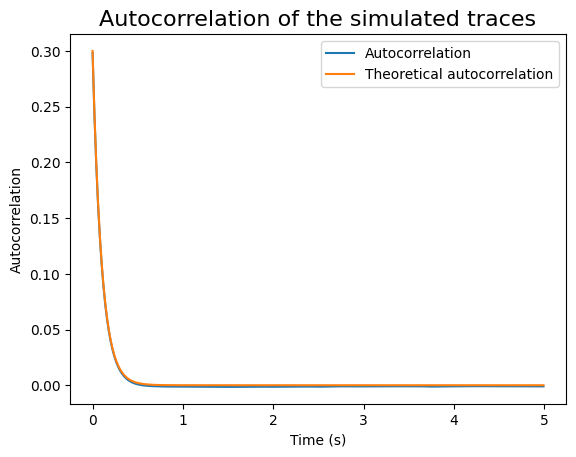

In [23]:
# Generate some traces
x = OrnsteinUhlenbeck(ModelParameter, n_sim = 10000, dt = dt, TotalT = 50)

# Calculate the autocorrelation
autocorrelation = np.array([stat_corr_single(x[i], dt) for i in range(x.shape[0])])
autocorrelation = np.mean(autocorrelation, axis = 0)

def OU_autocorrelation(t, k, D):
    return (D/k) * np.exp(-k*t)


t_max = int(5/dt)
fig, ax = plt.subplots()
ax.plot(t[:t_max], autocorrelation[:t_max], label = "Autocorrelation")
ax.plot(t[:t_max], OU_autocorrelation(t, ModelParameter[0], ModelParameter[1])[:t_max], label = "Theoretical autocorrelation")
ax.set_title("Autocorrelation of the simulated traces", fontsize=16)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Autocorrelation")
ax.legend();

## Entropy Production

???

## Implementing SBI

In [58]:
def GenerateDataForSBI(n_sim, prior_limits, dt = 0.01, TotalT = 1, constant_k = None, constant_D = None, method = "RAW"):
    t = np.arange(0, TotalT, dt)
    
    # Generate the parameters
    if constant_k is not None:
        k_param = np.repeat(constant_k, n_sim)
    else:
        k_param = np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], n_sim)
    
    if constant_D is not None:
        D_param = np.repeat(constant_D, n_sim)
    else:
        D_param = np.random.uniform(prior_limits["D"][0], prior_limits["D"][1], n_sim)
    
    params = np.array([k_param, D_param])    
    
    # Simulate the data
    trace = OrnsteinUhlenbeck(params, n_sim, dt, TotalT)
    
    
    # Save the trace and the parameters in the correct format
    trace = torch.tensor(np.array(trace)).float()
    params = torch.tensor(np.array(params)).float()

    # Save the prior for MultiRound
    prior = utils.BoxUniform(low=torch.tensor([prior_limits["k"][0], prior_limits["D"][0]]), high=torch.tensor([prior_limits["k"][1], prior_limits["D"][1]]))
    prior, _, _ = process_prior(prior)
    
    # Apply Summary Statistics
    SummaryStat = ApplySummaryStatistics(trace.numpy(), method = method, t = t)
    SummaryStat = torch.tensor(SummaryStat).float()
    
    return SummaryStat, params.T, prior

def ApplySummaryStatistics(trace, method, t = None):
    if method == "RAW":
        return trace
    elif method == "correlation":
        return np.array([stat_corr_single(trace[i], dt) for i in range(trace.shape[0])])
    elif method == "correlation_fit":
        if t is None:
            raise ValueError("t must be provided")
        def OU_autocorrelation(t, k, D):
            return (D/k) * np.exp(-k*t)
        
        c = ApplySummaryStatistics(trace, method = "correlation")
        params = np.zeros((c.shape[0], 2))
        for i in range(c.shape[0]):
            popt, pcov = curve_fit(OU_autocorrelation, t, c[i], p0 = [1, 1])
            params[i] = popt
        
        return params
        
    else:
        raise ValueError("Method not recognized")

def CompleteSBIPipeline(n_sim, prior_limits, dt, TotalTime, method = "RAW", rounds = 1, constant_k = None, constant_D = None):
    t = np.arange(0, TotalTime, dt)
    x, theta, prior = GenerateDataForSBI(n_sim, prior_limits, dt, TotalTime, method = method, constant_k = constant_k, constant_D = constant_D)
    x_test, theta_test, _ = GenerateDataForSBI(1, prior_limits, dt, TotalTime, method = method, constant_k = constant_k, constant_D = constant_D)
    inference = SNPE(prior=prior)
    proposal = prior
    
    for _ in np.arange(rounds):
        density_estimator = inference.append_simulations(theta, x, proposal = proposal).train()
        posterior = inference.build_posterior(density_estimator)
        print("\n")
        proposal = posterior.set_default_x(x_test)
    
    
    samples = posterior.sample((100000,), x=x_test.reshape(1, x_test.shape[1]), show_progress_bars=False)
    centroids, centroid_spread = PlotSBIResults(samples, theta_test, prior_limits)
    prior_ranges = np.array([prior_limits["k"][1] - prior_limits["k"][0], prior_limits["D"][1] - prior_limits["D"][0]])
    compat = np.abs((centroids - theta_test) / prior_ranges) # Cambiare con i limiti della prior
    
    return centroids, centroid_spread, theta_test, compat

def LimitsForPlot(prior_limits):
    limits = []
    for key in prior_limits.keys():
        limits.append(prior_limits[key])
    return limits

def GetCentroid(samples):
    centroids = samples.mean(axis=0)
    centroid_spread = samples.std(axis=0)
    
    return centroids, centroid_spread

def PlotSBIResults(samples, theta_test, prior_limits, labels=[r"$k$", r"$D$"], **kwargs):
    centroids, centroid_spread = GetCentroid(samples)
    fig, axes = analysis.pairplot(samples, points=theta_test, limits=LimitsForPlot(prior_limits), figsize=(5, 3), labels=[r"$k$", r"$D$"], **kwargs)
    
    textstr1 = '\n'.join((
        r'$k_{SBI}=%.2f \pm %.2f$' % (centroids[0], centroid_spread[0]),
        r'$D_{SBI}=%.2f\pm %.2f$' % (centroids[1], centroid_spread[1])))
    
    textstr2 = '\n'.join((
        r'$k_{True}=%.2f$' % theta_test[0][0],
        r'$D_{True}=%.2f$' % theta_test[0][1]))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axes[-1,1].text(-1.2, 0, textstr1, transform=axes[-1,1].transAxes, fontsize=12,
            verticalalignment='top', bbox=props);
    
    axes[-1,0].text(0, 0.6, textstr2, transform=axes[-1,0].transAxes, fontsize=12,
            verticalalignment='top', bbox=props);
    
    return centroids, centroid_spread


### SBI: Raw Traces

 Neural network successfully converged after 42 epochs.



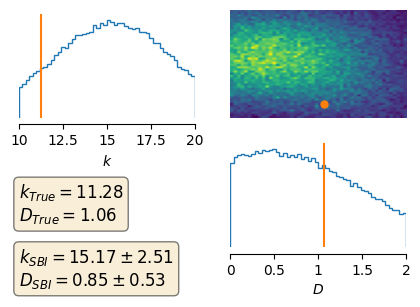

In [74]:
centroids, centroid_spread, theta_test, compat = CompleteSBIPipeline(100, prior_limits, dt, 70, method = "RAW", rounds = 1)

### SBI: Autocorrelation Traces

### SBI: Subsampling Autocorrelation Traces

### SBI: AutoCorrelation Fit

### SBI: Comparisons of Single-Round Inference

### SBI: Multi-Round Inference